# TTS Inference demo

In [1]:
BRANCH = 'main'

In [2]:
from ipywidgets import Select, HBox, Label
from IPython.display import display

supported_spec_gen = ["tacotron2", None]
supported_audio_gen = ["hifigan", "griffin-lim", None]

print("Select the model(s) that you want to use. Please choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.")
spectrogram_generator_selector = Select(options=supported_spec_gen, value=None)
audio_generator_selector = Select(options=supported_audio_gen, value=None)
display(HBox([spectrogram_generator_selector, Label("+"), audio_generator_selector]))

Select the model(s) that you want to use. Please choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.


In [6]:

spectrogram_generator = spectrogram_generator_selector.value
audio_generator = audio_generator_selector.value
print(spectrogram_generator, audio_generator)

tacotron2 hifigan


In [7]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder, TextToWaveform


def load_spectrogram_model():
    override_conf = None
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        pretrained_model = "tts_en_tacotron2"
    elif spectrogram_generator == "glow_tts":
        from nemo.collections.tts.models import GlowTTSModel
        pretrained_model = "tts_en_glowtts"
        import wget
        from pathlib import Path
        if not Path("cmudict-0.7b").exists():
            filename = wget.download("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b")
            filename = str(Path(filename).resolve())
        else:
            filename = str(Path("cmudict-0.7b").resolve())
        conf = SpectrogramGenerator.from_pretrained(pretrained_model, return_config=True)
        if "params" in conf.parser:
            conf.parser.params.cmu_dict_path = filename
        else:
            conf.parser.cmu_dict_path = filename
        override_conf = conf
    elif spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetSpectModel
        pretrained_model = "tts_en_talknet" 
    elif spectrogram_generator == "fastpitch":
        from nemo.collections.tts.models import FastPitchModel
        pretrained_model = "tts_en_fastpitch"
    elif spectrogram_generator == "fastspeech2":
        from nemo.collections.tts.models import FastSpeech2Model
        pretrained_model = "tts_en_fastspeech2"
    else:
        raise NotImplementedError

    model = SpectrogramGenerator.from_pretrained(pretrained_model, override_config_path=override_conf)
    
    if spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetPitchModel
        pitch_model = TalkNetPitchModel.from_pretrained(pretrained_model, override_config_path=override_conf)
        from nemo.collections.tts.models import TalkNetDursModel
        durs_model = TalkNetDursModel.from_pretrained(pretrained_model, override_config_path=override_conf)
        model.add_module('_pitch_model', pitch_model)
        model.add_module('_durs_model', durs_model)
    
    return model


def load_vocoder_model():
    RequestPseudoInverse = False
    TwoStagesModel = False
    strict=True
    
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "tts_waveglow"
        strict=False
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel
        pretrained_model = "tts_squeezewave"
    elif audio_generator == "uniglow":
        from nemo.collections.tts.models import UniGlowModel
        pretrained_model = "tts_uniglow"
    elif audio_generator == "melgan":
        from nemo.collections.tts.models import MelGanModel
        pretrained_model = "tts_melgan"
    elif audio_generator == "hifigan":
        from nemo.collections.tts.models import HifiGanModel
        pretrained_model = "tts_hifigan"
    elif audio_generator == "griffin-lim":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': 1024, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': 22050, 'n_fft': 1024, 
                                   'mel_fmin': 0, 'mel_fmax': 8000, 'mel_freq': 80}}}
        model = TwoStagesModel(cfg)            
        TwoStagesModel = True
    else:
        raise NotImplementedError

    if not TwoStagesModel:
        model = Vocoder.from_pretrained(pretrained_model, strict=strict)
    return model

emodel = None
spec_gen = None
vocoder = None
spec_gen = load_spectrogram_model().eval().cuda()
vocoder = load_vocoder_model().eval().cuda()

[NeMo I 2021-12-01 23:59:33 cloud:56] Found existing object /home/syl20/.cache/torch/NeMo/NeMo_1.5.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo.
[NeMo I 2021-12-01 23:59:33 cloud:62] Re-using file from: /home/syl20/.cache/torch/NeMo/NeMo_1.5.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo
[NeMo I 2021-12-01 23:59:33 common:729] Instantiating model from pre-trained checkpoint


[NeMo W 2021-12-01 23:59:33 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      trim: false
      int_values: false
      load_audio: true
      normalize: true
      sample_rate: 22050
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 48
      num_workers: 4
    
[NeMo W 2021-12-01 23:59:33 modelPT:137] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_

[NeMo I 2021-12-01 23:59:33 features:264] PADDING: 16
[NeMo I 2021-12-01 23:59:33 features:281] STFT using torch
[NeMo I 2021-12-01 23:59:34 save_restore_connector:149] Model Tacotron2Model was successfully restored from /home/syl20/.cache/torch/NeMo/NeMo_1.5.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo.
[NeMo I 2021-12-01 23:59:34 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /home/syl20/.cache/torch/NeMo/NeMo_1.5.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2021-12-02 00:00:04 common:729] Instantiating model from pre-trained checkpoint


[NeMo W 2021-12-02 00:00:06 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2021-12-02 00:00:06 modelPT:137] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2021-12-02 00:00:06 features:264] PADDING: 0
[NeMo I 2021-12-02 00:00:06 features:281] STFT using torch


[NeMo W 2021-12-02 00:00:06 features:241] Using torch_stft is deprecated and will be removed in 1.1.0. Please set stft_conv and stft_exact_pad to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2021-12-02 00:00:06 features:264] PADDING: 0
[NeMo I 2021-12-02 00:00:06 features:281] STFT using torch
[NeMo I 2021-12-02 00:00:08 save_restore_connector:149] Model HifiGanModel was successfully restored from /home/syl20/.cache/torch/NeMo/NeMo_1.5.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [8]:
def infer(spec_gen_model, vocder_model, str_input):
    parser_model = emodel or spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        spectrogram = spec_gen.generate_spectrogram(tokens=parsed)
        audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [9]:
print(spec_gen)

Tacotron2Model(
  (audio_to_melspec_precessor): FilterbankFeatures()
  (text_embedding): Embedding(69, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
     

In [11]:
text_to_generate = "Hi!"
spec, audio = infer(spec_gen, vocoder, text_to_generate)

# Synthesize

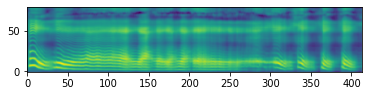

In [12]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline
imshow(spec, origin="lower")
plt.show()

ipd.Audio(audio, rate=22050)


In [35]:
!ls $DATA/en/LJSpeech-1.1/wavs/LJ001-000*

/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0001.wav
/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0002.wav
/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0003.wav
/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0004.wav
/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0005.txt
/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0005.wav
/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0006.wav
/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0007.wav
/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0008.txt
/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0008.wav
/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0009.wav


In [52]:
ipd.Audio('/home/syl20/data/en/LJSpeech-1.1/wavs/LJ001-0005.wav')